# Example of a classification task using RNN

For a similar example, see also:

> NLP FROM SCRATCH: CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN
by Sean Robertson on [pytorch](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

## Data task
We work on a collection of dates represented with different formats. The task is to associate each date with the correct month, in spite of the date format.

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
data = pd.read_csv('../data/rome_dates.csv', index_col=0)

In [4]:
data.head(20)

,text,target,day,month,year,temperature,temperature_class
0,01-01-1960,1960-01-01,1,1,1960,3.638,1
1,01/01/1960,1960-01-01,1,1,1960,3.638,1
2,01.01.1960,1960-01-01,1,1,1960,3.638,1
3,01/01/1960,1960-01-01,1,1,1960,3.638,1
4,01.01.1960,1960-01-01,1,1,1960,3.638,1
5,"Fri 01, Jan 1960",1960-01-01,1,1,1960,3.638,1
6,"Jan 01, 1960",1960-01-01,1,1,1960,3.638,1
7,"Fri 01, January 1960",1960-01-01,1,1,1960,3.638,1
8,1960/01/01,1960-01-01,1,1,1960,3.638,1
9,1960 January 01,1960-01-01,1,1,1960,3.638,1


### Get a subset of dates with month names

In [5]:
from datetime import datetime

In [6]:
selected_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
                  'October', 'November', 'December']
date_list, month_list, dates_list = data.text.values, data.month.values, data.target.values
dataset = []
for i, d in enumerate(date_list):
    for m in selected_months:
        if m in d:
#            dt = datetime.strptime(dates_list[i], '%Y-%m-%d')
            parts = d.split(m)
            dataset.append(("{}{}".format(parts[0], m), month_list[i]))
            break

In [7]:
dataset[:6]

[('Fri 01, January', 1),
 ('1960 January', 1),
 ('Sat 02, January', 1),
 ('1960 January', 1),
 ('Sun 03, January', 1),
 ('1960 January', 1)]

## Prepare data
In this example, we read each date (text) as a **sequence of chars** represented according to the one-hot encoding scheme.

In [8]:
import string
import torch

### Date strings to PyTorch tensors

In [9]:
alphabet = string.ascii_letters + string.digits + " -./,"

In [10]:
def date2tensor(date_text):
    tensor = torch.zeros(len(date_text), 1, len(alphabet))
    for i, char in enumerate(date_text):
        tensor[i][0][alphabet.find(char)] = 1
    return tensor

def tensor2date(date_tensor):
    return "".join([alphabet[x] for x in torch.nonzero(date_tensor)[:,2]])

#### Example

In [11]:
dt = date2tensor('Sun 03, January')
td = tensor2date(dt)

In [12]:
dt.size()

torch.Size([15, 1, 67])

In [13]:
dt[:2]

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [14]:
td

'Sun 03, January'

## RNN network structure

![rnn](../data/rnn.png)

In [15]:
import torch.nn as nn

In [16]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden):
        combined = torch.cat((input_tensor, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [17]:
hidden_size = 128
rnn = RNN(len(alphabet), hidden_size, len(selected_months))

### Forward step

In [18]:
date_tensor = date2tensor('Sun 03, January')
hidden_tensor = rnn.init_hidden()

In [19]:
output, next_hidden = rnn(date_tensor[0], hidden_tensor)

In [20]:
output

tensor([[-2.5066, -2.3869, -2.3978, -2.5525, -2.5709, -2.4713, -2.4918, -2.3893,
         -2.5823, -2.4691, -2.5687, -2.4598]], grad_fn=<LogSoftmaxBackward0>)

## Training

In [21]:
def output2month(output):
    top_n, top_i = output.topk(1)
    return selected_months[top_i[0].item()]

In [22]:
output2month(output)

'February'

### Create a training data generator

In [23]:
def create_training():
    date_string, month = dataset[np.random.choice(range(len(dataset)))]
    date_tensor = date2tensor(date_string)
    target_tensor = torch.tensor([month-1], dtype=torch.long)
    return date_tensor, target_tensor, date_string, month

In [25]:
input_t, target, date_string, month = create_training()
print(target, date_string, month)

tensor([8]) 1984 September 9


### Training

In [26]:
loss_function = nn.NLLLoss()
learning_rate = 0.005

In [27]:
def train(target_tensor, date_tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    for i in range(date_tensor.size()[0]):
        output, hidden = rnn(date_tensor[i], hidden)
    loss = loss_function(output, target_tensor)
    loss.backward()
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

#### Example

In [28]:
date_tensor, target_tensor, date_text, month = create_training()
output, loss = train(target_tensor, date_tensor)

In [29]:
loss

2.4746501445770264

In [30]:
print(date_text)
print(tensor2date(date_tensor))
print(output2month(output))

1987 June
1987 June
March


### Training with more data

In [31]:
hidden_size = 128
rnn = RNN(len(alphabet), hidden_size, len(selected_months))

In [32]:
epochs = 3000
error_history = []
run = list(enumerate(range(epochs)))
e = 0
log_period = 50

for i, epoch in tqdm(run):
    date_tensor, target_tensor, date_text, month = create_training()
    output, loss = train(target_tensor, date_tensor)
    e += loss
    if i > 0 and i % log_period == 0:
        error_history.append(e / log_period)
        e = 0

  0%|          | 0/3000 [00:00<?, ?it/s]

#### Plot error rate

In [33]:
import matplotlib.pyplot as plt

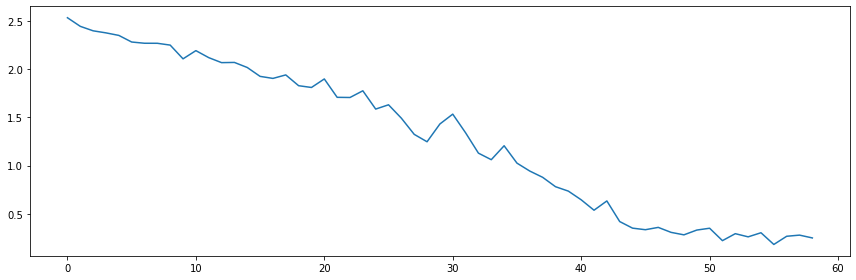

In [34]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(error_history)
plt.tight_layout()
plt.show()

## Test and evaluate

### Test

In [35]:
def predict(date_text):
    hidden = rnn.init_hidden()
    date_tensor = date2tensor(date_text)
    for char_tensor in date_tensor:
        output, hidden = rnn(char_tensor, hidden)
    return output

def output2month(output):
    return int(output.argmax() + 1)

In [37]:
output2month(predict('1, May'))

5

In [38]:
sample = np.random.choice([x for x, y in dataset], 10)
for d in sample:
    print(d, "month is", output2month(predict(d)))

1968 November month is 12
Wed 24, September month is 9
Sat 26, March month is 3
1971 April month is 4
1993 December month is 12
Mon 26, August month is 8
1967 June month is 6
Wed 11, August month is 8
2000 November month is 12
1965 March month is 3


In [42]:
output2month(predict('Christmass is on December'))

12

In [48]:
output2month(predict('3012 ril'))

4

### Evaluate

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [50]:
y_true, y_pred = [], []
for i in range(2000):
    date_tensor, target_tensor, date_text, month = create_training()
    y_true.append(selected_months[month-1])
    p = output2month(predict(date_text))
    y_pred.append(selected_months[p-1])

In [52]:
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

       April       1.00      1.00      1.00       144
      August       1.00      1.00      1.00       153
    December       0.51      1.00      0.68       159
    February       1.00      1.00      1.00       122
     January       1.00      1.00      1.00       160
        July       1.00      1.00      1.00       148
        June       1.00      1.00      1.00       141
       March       1.00      1.00      1.00       155
         May       1.00      1.00      1.00       364
    November       0.00      0.00      0.00       151
     October       1.00      1.00      1.00       164
   September       1.00      1.00      1.00       139

    accuracy                           0.92      2000
   macro avg       0.88      0.92      0.89      2000
weighted avg       0.89      0.92      0.90      2000



In [53]:
cm = confusion_matrix(y_true, y_pred, labels=selected_months)

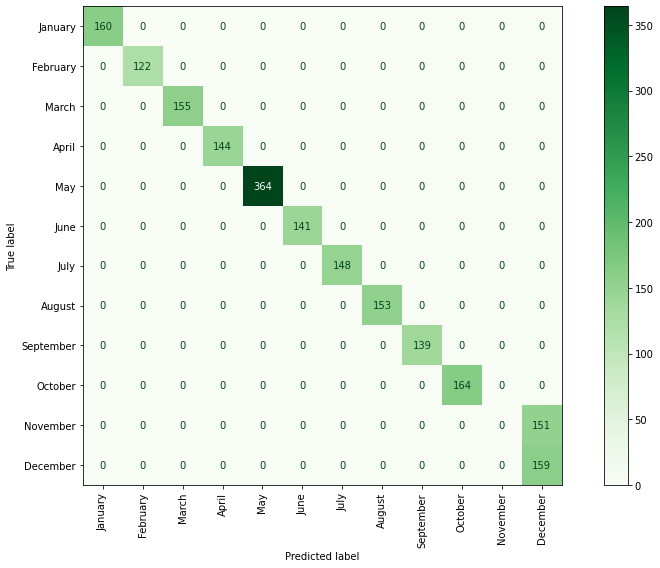

In [54]:
fig, ax = plt.subplots(figsize=(12, 8))
dis = ConfusionMatrixDisplay(cm, display_labels=selected_months)
dis.plot(ax=ax, cmap='Greens', xticks_rotation='vertical')
plt.tight_layout()
plt.show()